# Import data

In [1]:
%matplotlib inline

import glob
import os
import numpy as np
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.layers import Convolution2D, MaxPooling2D, ZeroPadding2D
from keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from keras import optimizers
from keras.models import Model
from keras import applications
from keras.utils.np_utils import to_categorical 
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()

Using TensorFlow backend.


In [2]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [17]:
# Dimensions of our images.
img_width, img_height = 240, 240

# epochs and batch_size
epochs = 100
batch_size = 32

# path to train and validation data
train_data_dir = '/dev/shm/train_sample'
valid_data_dir = '/dev/shm/valid_sample'
# train_data_dir = '/dev/shm/train'
# valid_data_dir = '/dev/shm/valid'

In [18]:
datagen = ImageDataGenerator(rescale=1./255)

In [19]:
train_generator = datagen.flow_from_directory(
        train_data_dir,
        target_size=(img_width, img_height),
        batch_size=batch_size)

Found 4911 images belonging to 46 classes.


In [21]:
valid_generator = datagen.flow_from_directory(
        valid_data_dir,
        target_size=(img_width, img_height),
        batch_size=batch_size)

Found 1690 images belonging to 46 classes.


In [23]:
n_classes = 46
train_samples = 4911
valid_samples = 1690
# n_classes = 6451
# train_samples = 859486
# valid_samples = 294058

# Basic CNN

In [24]:
model = Sequential()
model.add(Convolution2D(32, (3, 3), input_shape=(img_width, img_height, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Convolution2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Convolution2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Convolution2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Convolution2D(128, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(n_classes))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

In [25]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_15 (Conv2D)           (None, 238, 238, 32)      896       
_________________________________________________________________
activation_23 (Activation)   (None, 238, 238, 32)      0         
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 119, 119, 32)      0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 117, 117, 32)      9248      
_________________________________________________________________
activation_24 (Activation)   (None, 117, 117, 32)      0         
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 58, 58, 32)        0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 56, 56, 64)        18496     
__________

In [27]:
# Model saving callback
checkpointer = ModelCheckpoint(filepath='models/basic_cnn.h5', monitor='val_acc', verbose=1, save_best_only=True)

# Early stopping
early_stopping = EarlyStopping(monitor='val_acc', verbose=1, patience=5)

history = model.fit_generator(
        train_generator,
        steps_per_epoch=np.ceil(train_samples/float(batch_size)),
        epochs=epochs,
        callbacks=[checkpointer, early_stopping],
        verbose=2,
        validation_data=valid_generator,
        validation_steps=np.ceil(valid_samples/float(batch_size)))

Epoch 1/100
Epoch 00000: val_acc improved from -inf to 0.58107, saving model to models/basic_cnn.h5
23s - loss: 2.0450 - acc: 0.5018 - val_loss: 1.7531 - val_acc: 0.5811
Epoch 2/100
Epoch 00001: val_acc improved from 0.58107 to 0.63728, saving model to models/basic_cnn.h5
23s - loss: 1.5814 - acc: 0.6030 - val_loss: 1.4266 - val_acc: 0.6373
Epoch 3/100
Epoch 00002: val_acc improved from 0.63728 to 0.70355, saving model to models/basic_cnn.h5
23s - loss: 1.2872 - acc: 0.6696 - val_loss: 1.2113 - val_acc: 0.7036
Epoch 4/100
Epoch 00003: val_acc improved from 0.70355 to 0.72189, saving model to models/basic_cnn.h5
23s - loss: 1.0467 - acc: 0.7261 - val_loss: 1.1119 - val_acc: 0.7219
Epoch 5/100
Epoch 00004: val_acc improved from 0.72189 to 0.75266, saving model to models/basic_cnn.h5
23s - loss: 0.8587 - acc: 0.7748 - val_loss: 1.0015 - val_acc: 0.7527
Epoch 6/100
Epoch 00005: val_acc improved from 0.75266 to 0.75562, saving model to models/basic_cnn.h5
23s - loss: 0.7037 - acc: 0.8094 - 

In [28]:
model.evaluate_generator(valid_generator, valid_samples)

[1.2828314637822251, 0.81383610537580953]

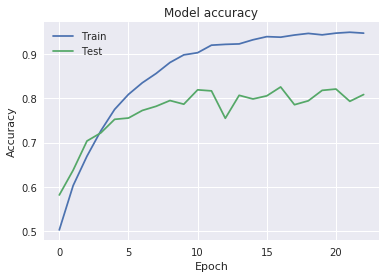

In [29]:
fig, ax = plt.subplots()
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Data Augumentation

In [30]:
train_datagen_augmented = ImageDataGenerator(
        rescale=1. / 255,      
        shear_range=0.2,       
        zoom_range=0.2,        
        horizontal_flip=True)  

In [31]:
train_generator = train_datagen_augmented.flow_from_directory(
        train_data_dir,
        target_size=(img_width, img_height),
        batch_size=batch_size)

Found 4911 images belonging to 46 classes.


In [32]:
# Model saving callback
checkpointer = ModelCheckpoint(filepath='models/data_augmentation.h5', monitor='val_acc', verbose=1, save_best_only=True)

# Early stopping
early_stopping = EarlyStopping(monitor='val_acc', verbose=1, patience=5)

history = model.fit_generator(
        train_generator,
        steps_per_epoch=np.ceil(train_samples/float(batch_size)),
        epochs=epochs,
        callbacks=[checkpointer, early_stopping],
        verbose=2,
        validation_data=valid_generator,
        validation_steps=np.ceil(valid_samples/float(batch_size)))

Epoch 1/100
Epoch 00000: val_acc improved from -inf to 0.78225, saving model to models/data_augmentation.h5
47s - loss: 1.0868 - acc: 0.7383 - val_loss: 1.0075 - val_acc: 0.7822
Epoch 2/100
Epoch 00001: val_acc improved from 0.78225 to 0.79053, saving model to models/data_augmentation.h5
44s - loss: 0.8976 - acc: 0.7762 - val_loss: 0.9516 - val_acc: 0.7905
Epoch 3/100
Epoch 00002: val_acc did not improve
44s - loss: 0.8161 - acc: 0.7905 - val_loss: 1.0838 - val_acc: 0.7331
Epoch 4/100
Epoch 00003: val_acc did not improve
44s - loss: 0.7522 - acc: 0.8006 - val_loss: 1.0045 - val_acc: 0.7763
Epoch 5/100
Epoch 00004: val_acc improved from 0.79053 to 0.79112, saving model to models/data_augmentation.h5
44s - loss: 0.6938 - acc: 0.8198 - val_loss: 0.9514 - val_acc: 0.7911
Epoch 6/100
Epoch 00005: val_acc did not improve
45s - loss: 0.6872 - acc: 0.8224 - val_loss: 1.3474 - val_acc: 0.7361
Epoch 7/100
Epoch 00006: val_acc improved from 0.79112 to 0.82544, saving model to models/data_augmenta

In [33]:
model.evaluate_generator(valid_generator, valid_samples)

[1.2354771347407854, 0.80637618848023107]

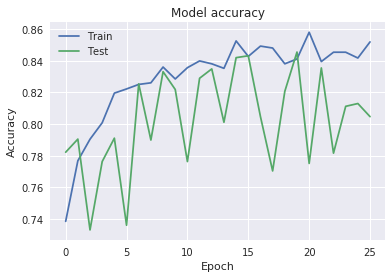

In [34]:
fig, ax = plt.subplots()
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# VGG 16 models

In [70]:
model_vgg = applications.VGG16(include_top=False, weights='imagenet')

In [71]:
bottleneck_features_train = model_vgg.predict_generator(train_generator, np.ceil(train_samples/float(batch_size)))
#np.save(open('/dev/shm/models/bottleneck_features_train.npy', 'wb'), bottleneck_features_train)

In [72]:
bottleneck_features_validation = model_vgg.predict_generator(valid_generator, np.ceil(valid_samples/float(batch_size)))
#np.save(open('/dev/shm/models/bottleneck_features_validation.npy', 'wb'), bottleneck_features_validation)

In [73]:
num_classes = len(train_generator.class_indices)

train_data = bottleneck_features_train
train_labels = to_categorical(train_generator.classes[:train_samples], num_classes=num_classes)

validation_data = bottleneck_features_validation
validation_labels = to_categorical(valid_generator.classes[:valid_samples], num_classes=num_classes)

In [74]:
model_top = Sequential()
model_top.add(Flatten(input_shape=train_data.shape[1:]))
model_top.add(Dense(512, activation='relu'))
model_top.add(Dropout(0.5))
model_top.add(Dense(n_classes, activation='softmax'))

model_top.compile(loss='categorical_crossentropy',
                  optimizer='rmsprop',
                  metrics=['accuracy'])

In [75]:
model_top.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_10 (Flatten)         (None, 25088)             0         
_________________________________________________________________
dense_17 (Dense)             (None, 512)               12845568  
_________________________________________________________________
dropout_9 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_18 (Dense)             (None, 46)                23598     
Total params: 12,869,166
Trainable params: 12,869,166
Non-trainable params: 0
_________________________________________________________________


In [76]:
# Model saving callback
checkpointer = ModelCheckpoint(filepath='models/bottleneck_features.h5', monitor='val_acc', verbose=1, save_best_only=True)

# Early stopping
early_stopping = EarlyStopping(monitor='val_acc', verbose=1, patience=5)

history = model_top.fit(
        train_data,
        train_labels,
        verbose=2,
        epochs=epochs, 
        batch_size=batch_size,
        callbacks=[checkpointer, early_stopping],
        validation_data=(validation_data, validation_labels))

Train on 4911 samples, validate on 1690 samples
Epoch 1/100
Epoch 00000: val_acc improved from -inf to 0.13491, saving model to models/bottleneck_features.h5
3s - loss: 5.9084 - acc: 0.1045 - val_loss: 3.1428 - val_acc: 0.1349
Epoch 2/100
Epoch 00001: val_acc did not improve
2s - loss: 3.3084 - acc: 0.1254 - val_loss: 3.1010 - val_acc: 0.1254
Epoch 3/100
Epoch 00002: val_acc did not improve
2s - loss: 3.2197 - acc: 0.1354 - val_loss: 3.1682 - val_acc: 0.1083
Epoch 4/100
Epoch 00003: val_acc did not improve
2s - loss: 3.1714 - acc: 0.1299 - val_loss: 3.1543 - val_acc: 0.1183
Epoch 5/100
Epoch 00004: val_acc did not improve
2s - loss: 3.1409 - acc: 0.1366 - val_loss: 3.2755 - val_acc: 0.1207
Epoch 6/100
Epoch 00005: val_acc improved from 0.13491 to 0.13669, saving model to models/bottleneck_features.h5
3s - loss: 3.1425 - acc: 0.1364 - val_loss: 3.1576 - val_acc: 0.1367
Epoch 7/100
Epoch 00006: val_acc did not improve
2s - loss: 3.1075 - acc: 0.1381 - val_loss: 3.2965 - val_acc: 0.1189
E

In [77]:
model_top.evaluate(validation_data, validation_labels)

1440/1690 [========================>.....] - ETA: 0s

[3.4217607630780464, 0.10532544383106852]

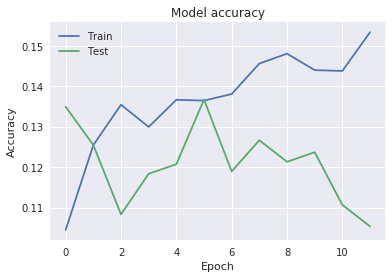

In [78]:
fig, ax = plt.subplots()
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Fine Tuning

In [81]:
model_vgg = applications.VGG16(include_top=False, weights='imagenet', input_shape=(img_width, img_height, 3))

In [82]:
top_model = Sequential()
top_model.add(Flatten(input_shape=model_vgg.output_shape[1:]))
top_model.add(Dense(512, activation='relu'))
top_model.add(Dropout(0.5))
top_model.add(Dense(n_classes, activation='softmax'))

top_model.load_weights('models/bottleneck_features.h5')

model = Model(inputs=model_vgg.input, outputs=top_model(model_vgg.output))

In [83]:
for layer in model.layers[:15]:
    layer.trainable = False

In [84]:
# Compile the model with a SGD/momentum optimizer and a slow learning rate
model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.SGD(lr=1e-4, momentum=0.9),
              metrics=['accuracy'])

In [85]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         (None, 240, 240, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 240, 240, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 240, 240, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 120, 120, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 120, 120, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 120, 120, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 60, 60, 128)       0         
__________

# Training

In [86]:
# Model saving callback
checkpointer = ModelCheckpoint(filepath='models/finetuning_full.h5', monitor='val_acc', verbose=1, save_best_only=True)

# Early stopping
early_stopping = EarlyStopping(monitor='val_acc', verbose=1, patience=5)

history = model.fit_generator(
        train_generator,
        steps_per_epoch=np.ceil(train_samples/float(batch_size)),
        epochs=epochs,
        callbacks=[checkpointer, early_stopping],
        verbose=2,
        validation_data=valid_generator,
        validation_steps=np.ceil(valid_samples/float(batch_size)))

Epoch 1/100
Epoch 00000: val_acc improved from -inf to 0.23314, saving model to models/finetuning_full.h5
143s - loss: 3.0739 - acc: 0.1763 - val_loss: 2.8735 - val_acc: 0.2331
Epoch 2/100
Epoch 00001: val_acc improved from 0.23314 to 0.23905, saving model to models/finetuning_full.h5
143s - loss: 2.8173 - acc: 0.2213 - val_loss: 2.6704 - val_acc: 0.2391
Epoch 3/100
Epoch 00002: val_acc improved from 0.23905 to 0.36746, saving model to models/finetuning_full.h5
143s - loss: 2.6665 - acc: 0.2781 - val_loss: 2.4235 - val_acc: 0.3675
Epoch 4/100
Epoch 00003: val_acc improved from 0.36746 to 0.50592, saving model to models/finetuning_full.h5
143s - loss: 2.4675 - acc: 0.3468 - val_loss: 2.2101 - val_acc: 0.5059
Epoch 5/100
Epoch 00004: val_acc improved from 0.50592 to 0.56272, saving model to models/finetuning_full.h5
144s - loss: 2.2842 - acc: 0.4086 - val_loss: 2.0045 - val_acc: 0.5627
Epoch 6/100
Epoch 00005: val_acc did not improve
142s - loss: 2.1507 - acc: 0.4573 - val_loss: 1.8892 -

# Evaluation

In [ ]:
model.evaluate_generator(valid_generator, valid_samples)

In [ ]:
fig, ax = plt.subplots()
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()